In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import psutil
from functools import reduce
from tqdm import tqdm_notebook
from multiprocessing import Process
from numpy.fft import rfft, rfftfreq, irfft
import gen_features
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in multiple train chunks 

In [2]:
### Read training sets and confirm indices
seg_nums = range(56,70)
segment_list = []
for k in seg_nums:
    data = pd.read_csv(os.path.join("Data","train_chunk{0}.csv".format(k))).iloc[:,1:]
    for i in [5,18,24]:
        start = i*150000
        stop = (i+1)*150000
        segment_list.append(data.loc[start:stop])

In [23]:
def add_time_to_failure(axis,segment,segment_list):
    axis2 = axis.twinx()
    axis2.axhline(segment['time_to_failure'].iloc[-1],color='r')
    axis2.set_ylim((min(s['time_to_failure'].min() for s in segment_list),
                max(s['time_to_failure'].max() for s in segment_list)+1))

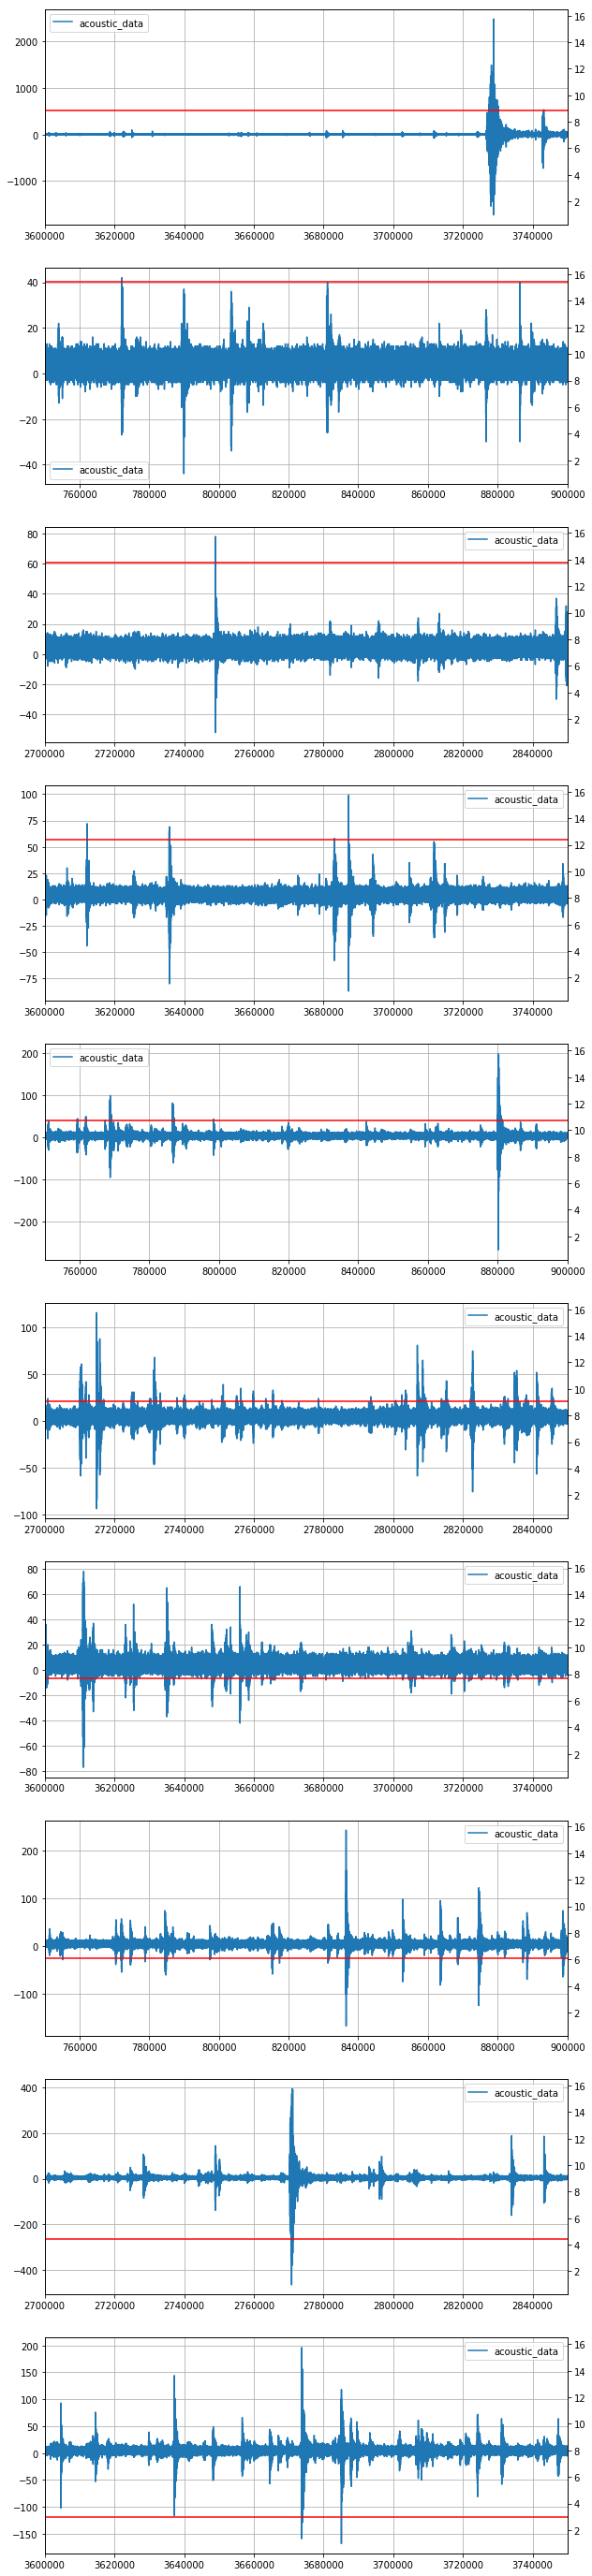

In [127]:
nrows = min(10,len(segment_list)+1)
filt_segment_list = [segment_list[17]] + list(segment_list[::int(len(segment_list)/nrows)])
fig, axes = plt.subplots(nrows,1,figsize=(10,5*nrows))
for segment,axis in zip(filt_segment_list,axes):
    axis.plot(segment.index,segment['acoustic_data'])
    add_time_to_failure(axis,segment,segment_list)
    axis.legend()
    axis.grid()
    axis.set_xlim((segment.index[0],segment.index[-1]))

### Generate and plot ffts

In [13]:
freq = rfftfreq(150000,d=1/4e6)
fft_list = [rfft(segment['acoustic_data']) for segment in segment_list]
low_pass_freq = 2e5 #5e5
high_pass_freq = 1e4
lp_fft_list = [fft*(freq<low_pass_freq) for fft in fft_list]
lp_segment_list = [irfft(lp_fft,150000) for lp_fft in lp_fft_list]
hp_fft_list = [fft*(freq>high_pass_freq) for fft in fft_list]
hp_segment_list = [irfft(hp_fft,150000) for hp_fft in hp_fft_list]
roll_fft_list = [rfft(segment['acoustic_data'].rolling(10).mean()[10:]) for segment in segment_list]
roll_freq = rfftfreq(len(segment['acoustic_data'].rolling(10).mean()[10:]),d=1/4e6)

Text(0.5, 1.0, 'High-Pass vs Regular FFTs')

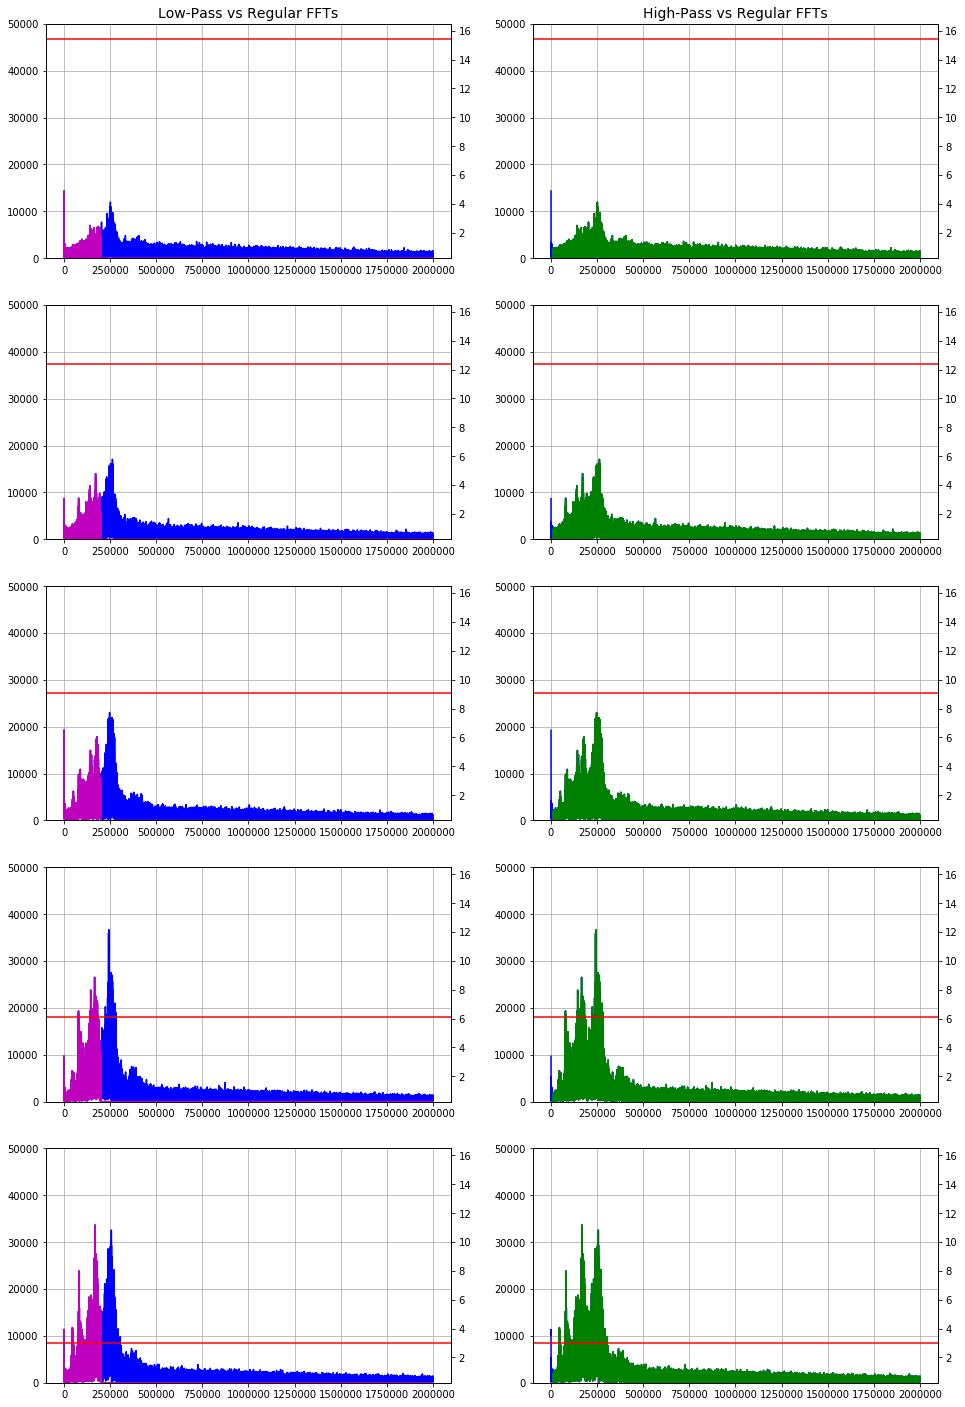

In [39]:
nrows = min(5,len(segment_list))
inc = int(len(segment_list)/nrows)

fig, axes = plt.subplots(nrows,2,figsize=(16,5*nrows))

fft_lims = [min(np.abs(fft[1:]).min() for fft in fft_list),
                50000]
            
for fft,lp_fft,hp_fft,segment,axis in zip(fft_list[::inc],lp_fft_list[::inc],
                                          hp_fft_list[::inc],segment_list[::inc],axes):
    
    axis[0].plot(freq[1:],np.abs(fft[1:]),'b')
    axis[0].plot(freq[1:],np.abs(lp_fft[1:]),'m')
    axis[0].grid()
    axis[0].set_ylim(fft_lims)
    add_time_to_failure(axis[0],segment,segment_list)
    
    axis[1].plot(freq[1:],np.abs(fft[1:]),'b')
    axis[1].plot(freq[1:],np.abs(hp_fft[1:]),'g')
    axis[1].grid()
    axis[1].set_ylim(fft_lims)
    add_time_to_failure(axis[1],segment,segment_list)

axes[0,0].set_title('Low-Pass vs Regular FFTs',fontsize=14)
axes[0,1].set_title('High-Pass vs Regular FFTs',fontsize=14)

### Set up features to capture the fft results

In [79]:
def envelop_cv(cv):
    return pd.Series(cv).rolling(500).max()

Text(0.5, 1.0, 'FFTs and feature division lines')

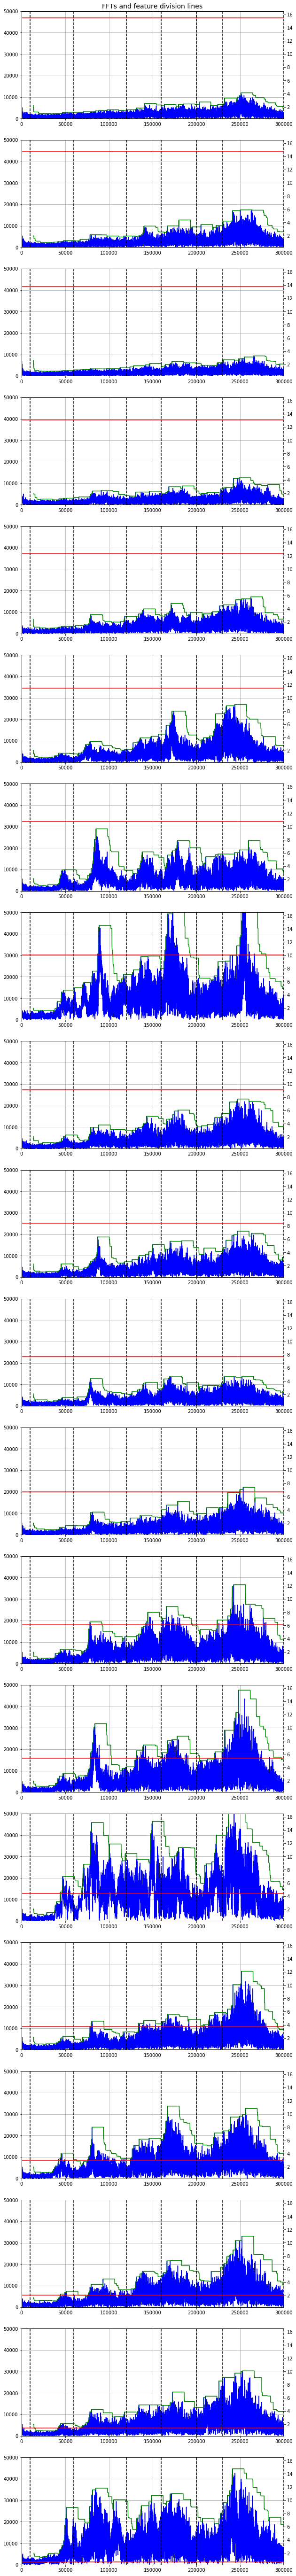

In [90]:
nrows = min(20,len(segment_list))
inc = int(len(segment_list)/nrows)
feat_divisions = [1e4,6e4,1.2e5,1.6e5,2e5,2.3e5,3e5]
fft_lims = [min(np.abs(fft[1:]).min() for fft in fft_list),
                50000]

fig, axes = plt.subplots(nrows,figsize=(10,5*nrows))
            
for fft,segment,axis in zip(fft_list[::inc],segment_list[::inc],axes):
    
    axis.plot(freq[1:],np.abs(fft[1:]),'b')
    axis.plot(freq[10:],envelop_cv(np.abs(fft[10:])),'g')
    axis.grid()
    axis.set_ylim(fft_lims)
    axis.set_xlim((0,3e5))
    for f in feat_divisions:
        axis.axvline(f,color='k',linestyle='--')
    add_time_to_failure(axis,segment,segment_list)

axes[0].set_title('FFTs and feature division lines',fontsize=14)

In [69]:
cv = np.abs(fft_list[5][np.argmax(freq>1e4):np.argmax(freq>3e5)])

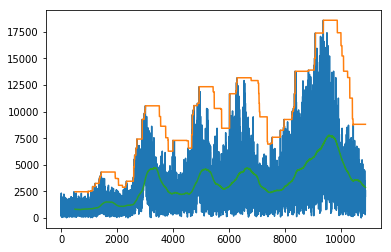

In [82]:
plt.plot(cv)
plt.plot(pd.Series(cv).rolling(500).max())
plt.plot(pd.Series(cv).rolling(500).mean())

In [103]:
feat_names = ["fft_[{:},{:}]Hz".format(int(i),int(j)) for (i,j) in zip(feat_divisions,feat_divisions[1:])]
feat_names

['fft_[10000,60000]Hz',
 'fft_[60000,120000]Hz',
 'fft_[120000,160000]Hz',
 'fft_[160000,200000]Hz',
 'fft_[200000,230000]Hz',
 'fft_[230000,300000]Hz']

In [116]:
def convert_fft_to_features(x_raw,feat_divisions,sample_freq = 4e6):

    feature_names = ["fft_[{:},{:}]Hz".format(int(i),int(j)) for (i,j) in zip(feat_divisions,feat_divisions[1:])]

    freq = rfftfreq(len(x_raw),d=1/sample_freq)
    fft = np.abs(rfft(x_raw))
    features = []
    
    for i,j in zip(feat_divisions,feat_divisions[1:]):
        start = np.argmax(freq>i)
        stop = np.argmax(freq>j)
        features.append(np.max(fft[start:stop]))
    
    return features, feature_names

In [117]:
convert_fft_to_features(segment_list[17]['acoustic_data'],feat_divisions)

([94163.0513082784,
  202792.81364850714,
  293796.99739889335,
  188545.9502843899,
  160312.85743494515,
  260863.57555616988],
 ['fft_[10000,60000]Hz',
  'fft_[60000,120000]Hz',
  'fft_[120000,160000]Hz',
  'fft_[160000,200000]Hz',
  'fft_[200000,230000]Hz',
  'fft_[230000,300000]Hz'])

In [136]:
data_x = []
data_y = []
for segment in segment_list:
    feats, feature_names = convert_fft_to_features(segment['acoustic_data'],feat_divisions)
    data_x.append(feats)
    data_y.append(segment['time_to_failure'].iloc[-1])
x_df = pd.DataFrame(data_x,columns=feature_names)
y_df = pd.DataFrame(data_y,columns=['time_to_failure'])
data = pd.concat([x_df,y_df],axis=1)

(0, 100000.0)

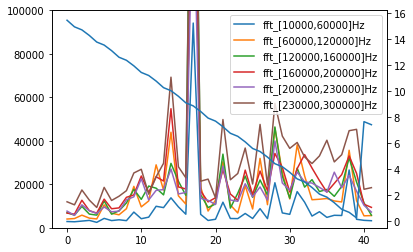

In [140]:
axis = data.iloc[:,:-1].plot()
axis2 = axis.twinx()
axis2.plot(data.iloc[:,-1])
axis.set_ylim((0,1e5))